In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from feature_engine.selection import DropCorrelatedFeatures
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import utils
from utils import pct_change, draw_pct_change

In [2]:
OUTLIER_RUL_THRESHOLD = 280
CORRELATION_THRESHOLD = 0.7
ENGINE_ID = 1
ROLLING_AVERAGE_WINDOW = 5
df = utils.load_data("CMAPSSData/train_FD001.txt")
df.describe()

engine_id          time  operational_setting_1  \
count  20631.000000  20631.000000           20631.000000   
mean      51.506568    108.807862              -0.000009   
std       29.227633     68.880990               0.002187   
min        1.000000      1.000000              -0.008700   
25%       26.000000     52.000000              -0.001500   
50%       52.000000    104.000000               0.000000   
75%       77.000000    156.000000               0.001500   
max      100.000000    362.000000               0.008700   

       operational_setting_2  operational_setting_3  Fan_inlet_temperature  \
count           20631.000000                20631.0               20631.00   
mean                0.000002                  100.0                 518.67   
std                 0.000293                    0.0                   0.00   
min                -0.000600                  100.0                 518.67   
25%                -0.000200                  100.0                 518.67   
50%                 0.000000                  100.0                 518.67   
75%                 0.000300                  100.0                 518.67   
max                 0.000600                  100.0                 518.67   

       LPC_outlet_temperature  HPC_outlet_temperature  LPT_outlet_temperature  \
count            20631.000000            20631.000000            20631.000000   
mean               642.680934             1590.523119             1408.933782   
std                  0.500053                6.131150                9.000605   
min                641.210000             1571.040000             1382.250000   
25%                642.325000             1586.260000             1402.360000   
50%                642.640000             1590.100000             1408.040000   
75%                643.000000             1594.380000             1414.555000   
max                644.530000             1616.910000             1441.490000   

       Fan_inlet_Pressure  ...  Ratio_of_fuel_flow_to_Ps30  \
count        2.063100e+04  ...                20631.000000   
mean         1.462000e+01  ...                  521.413470   
std          1.776400e-15  ...                    0.737553   
min          1.462000e+01  ...                  518.690000   
25%          1.462000e+01  ...                  520.960000   
50%          1.462000e+01  ...                  521.480000   
75%          1.462000e+01  ...                  521.950000   
max          1.462000e+01  ...                  523.380000   

       Corrected_fan_speed  Corrected_core_speed  Bypass_Ratio  \
count         20631.000000          20631.000000  20631.000000   
mean           2388.096152           8143.752722      8.442146   
std               0.071919             19.076176      0.037505   
min            2387.880000           8099.940000      8.324900   
25%            2388.040000           8133.245000      8.414900   
50%            2388.090000           8140.540000      8.438900   
75%            2388.140000           8148.310000      8.465600   
max            2388.560000           8293.720000      8.584800   

       Burner_fuel-air_ratio  Bleed_Enthalpy  Required_fan_speed  \
count           2.063100e+04    20631.000000             20631.0   
mean            3.000000e-02      393.210654              2388.0   
std             1.387812e-17        1.548763                 0.0   
min             3.000000e-02      388.000000              2388.0   
25%             3.000000e-02      392.000000              2388.0   
50%             3.000000e-02      393.000000              2388.0   
75%             3.000000e-02      394.000000              2388.0   
max             3.000000e-02      400.000000              2388.0   

       Required_fan_conversion_speed  High-pressure_turbines_Cool_air_flow  \
count                        20631.0                          20631.000000   
mean                           100.0                             38.816271   
std                              0.

In [3]:
df.nunique()

engine_id                                100
time                                     362
operational_setting_1                    158
operational_setting_2                     13
operational_setting_3                      1
Fan_inlet_temperature                      1
LPC_outlet_temperature                   310
HPC_outlet_temperature                  3012
LPT_outlet_temperature                  4051
Fan_inlet_Pressure                         1
bypass-duct_pressure                       2
HPC_outlet_pressure                      513
Physical_fan_speed                        53
Physical_core_speed                     6403
Engine_pressure_ratio(                     1
HPC_outlet_Static_pressure               159
Ratio_of_fuel_flow_to_Ps30               427
Corrected_fan_speed                       56
Corrected_core_speed                    6078
Bypass_Ratio                            1918
Burner_fuel-air_ratio                      1
Bleed_Enthalpy                            13
Required_f

## drop constant or nearly constant columns

In [4]:
# df = df.loc[:, df.nunique() > 13]

### Max cycles histogram


<Axes: >

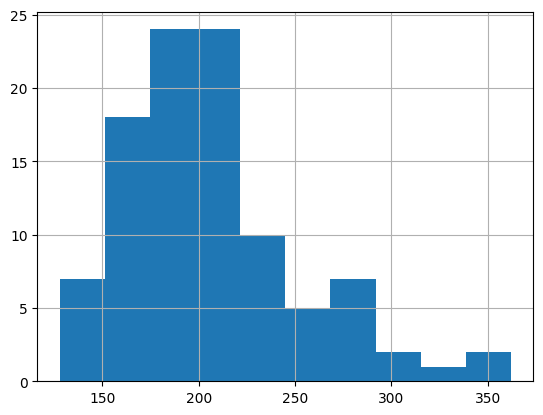

In [5]:
df.groupby(["engine_id"])["time"].max().hist()

### Drop outliers

<Axes: >

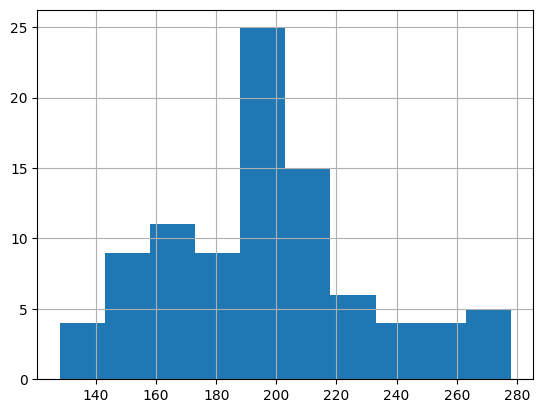

In [6]:
ids_to_drop = df.loc[df['time'] > OUTLIER_RUL_THRESHOLD, 'engine_id'].unique()
df = df[~df['engine_id'].isin(ids_to_drop)]
df.groupby(["engine_id"])["time"].max().hist()

In [7]:
features = list(df.columns)
features.remove('time')
features.remove('engine_id')
y = df.groupby('engine_id')['time'].transform('max') - df['time']
features_df = df[features]
features_df

operational_setting_1  operational_setting_2  operational_setting_3  \
0                    -0.0007                -0.0004                  100.0   
1                     0.0019                -0.0003                  100.0   
2                    -0.0043                 0.0003                  100.0   
3                     0.0007                 0.0000                  100.0   
4                    -0.0019                -0.0002                  100.0   
...                      ...                    ...                    ...   
20626                -0.0004                -0.0003                  100.0   
20627                -0.0016                -0.0005                  100.0   
20628                 0.0004                 0.0000                  100.0   
20629                -0.0011                 0.0003                  100.0   
20630                -0.0032                -0.0005                  100.0   

       Fan_inlet_temperature  LPC_outlet_temperature  HPC_outlet_temperature  \
0                     518.67                  641.82                 1589.70   
1                     518.67                  642.15                 1591.82   
2                     518.67                  642.35                 1587.99   
3                     518.67                  642.35                 1582.79   
4                     518.67                  642.37                 1582.85   
...                      ...                     ...                     ...   
20626                 518.67                  643.49                 1597.98   
20627                 518.67                  643.54                 1604.50   
20628                 518.67                  643.42                 1602.46   
20629                 518.67                  643.23                 1605.26   
20630                 518.67                  643.85                 1600.38   

       LPT_outlet_temperature  Fan_inlet_Pressure  bypass-duct_pressure  \
0                     1400.60               14.62                 21.61   
1                     1403.14               14.62                 21.61   
2                     1404.20               14.62                 21.61   
3                     1401.87               14.62                 21.61   
4                     1406.22               14.62                 21.61   
...                       ...                 ...                   ...   
20626                 1428.63               14.62                 21.61   
20627                 1433.58               14.62                 21.61   
20628                 1428.18               14.62                 21.61   
20629                 1426.53               14.62                 21.61   
20630                 1432.14               14.62                 21.61   

       HPC_outlet_pressure  ...  Ratio_of_fuel_flow_to_Ps30  \
0                   554.36  ...                      521.66   
1                   553.75  ...                      522.28   
2                   554.26  ...                      522.42   
3                   554.45  ...                      522.86   
4                   554.00  ...                      522.19   
...                    ...  ...                         ...   
20626               551.43  ...                      519.49   
20627               550.86  ...                      519.68   
20628               550.94  ...                      520.01   
20629               550.68  ...                      519.67   
20630               550.79  ...                      519.30   

       Corrected_fan_speed  Corrected_core_speed  Bypass_Ratio  \
0                  2388.02               8138.62        8.4195   
1                  2388.07               8131.49        8.4318   
2                  2388.03               8133.23        8.4178   
3                  2388.08               8133.83        8.3682   
4                  2388.04               8133.80        8.4294   
...                    ...                   ...       

In [8]:

f_scores, p_values = f_regression(features_df, y)
threshold = 0.05
significant_features = features_df.columns[p_values < threshold]
dropped_features = features_df.columns[p_values >= threshold]
df_filtered = df[significant_features]

print("Selected Features:")
print(significant_features)
print("Dropped features:")
print(dropped_features)
df = pd.merge(df[['time', 'engine_id']], df_filtered, left_index=True, right_index=True)

Selected Features:
Index(['LPC_outlet_temperature', 'HPC_outlet_temperature',
       'LPT_outlet_temperature', 'bypass-duct_pressure', 'HPC_outlet_pressure',
       'Physical_fan_speed', 'Physical_core_speed',
       'HPC_outlet_Static_pressure', 'Ratio_of_fuel_flow_to_Ps30',
       'Corrected_fan_speed', 'Corrected_core_speed', 'Bypass_Ratio',
       'Bleed_Enthalpy', 'High-pressure_turbines_Cool_air_flow',
       'Low-pressure_turbines_Cool_air_flow'],
      dtype='object')
Dropped features:
Index(['operational_setting_1', 'operational_setting_2',
       'operational_setting_3', 'Fan_inlet_temperature', 'Fan_inlet_Pressure',
       'Engine_pressure_ratio(', 'Burner_fuel-air_ratio', 'Required_fan_speed',
       'Required_fan_conversion_speed'],
      dtype='object')


/Users/pszmurlo/Documents/pw/PBAD1/.venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:379: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)


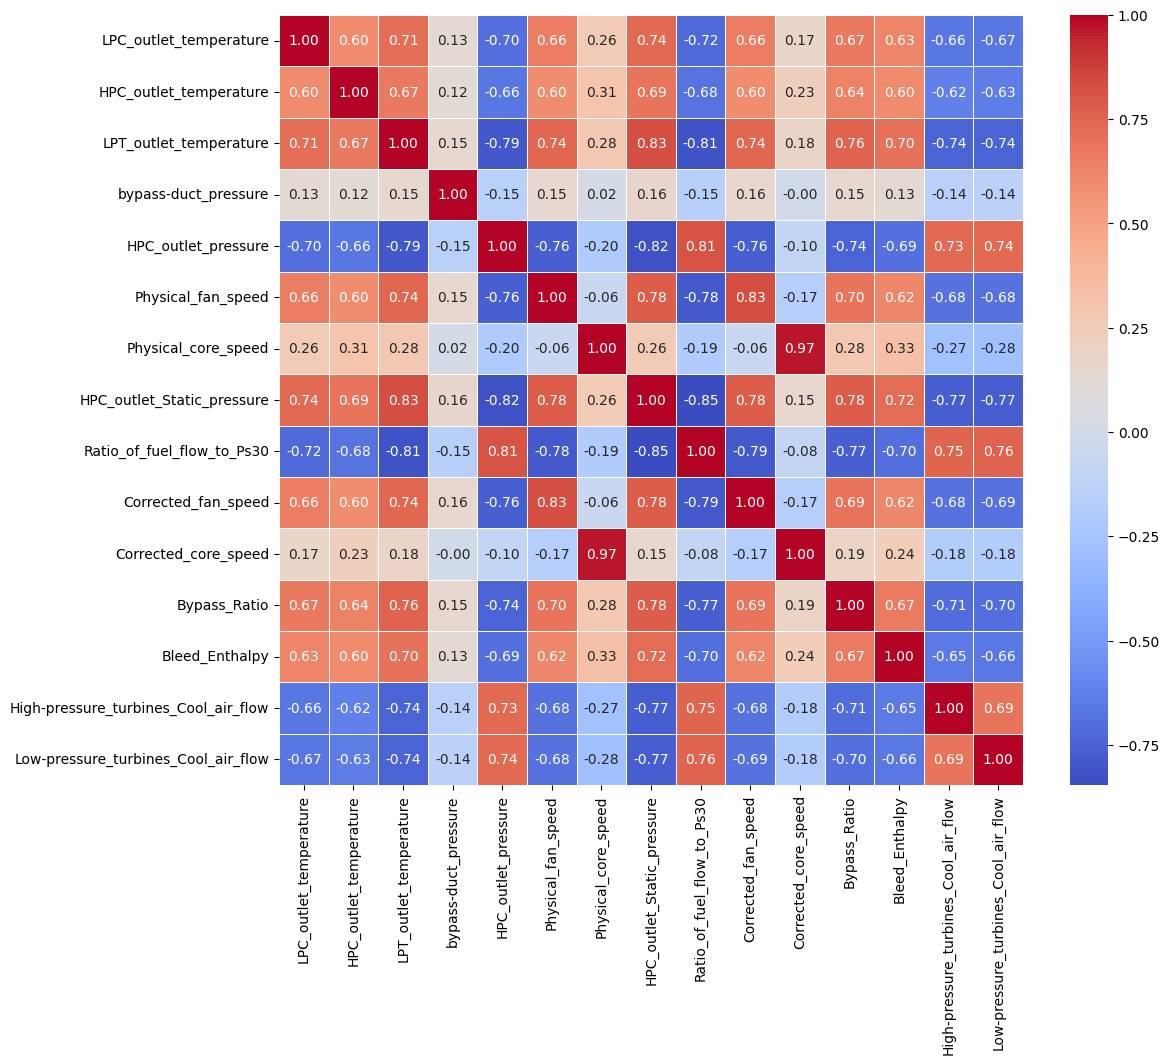

In [9]:
utils.draw_corr(df[significant_features])

In [10]:
features_df = df.drop(['time', 'engine_id'], axis=1)
dcf = DropCorrelatedFeatures(threshold=CORRELATION_THRESHOLD)
features_df = dcf.fit_transform(features_df)
df = pd.merge(df[['engine_id', 'time']], features_df, left_index=True, right_index=True)
df.columns

Index(['engine_id', 'time', 'LPC_outlet_temperature', 'HPC_outlet_temperature',
       'bypass-duct_pressure', 'Corrected_fan_speed', 'Corrected_core_speed',
       'Bypass_Ratio', 'Bleed_Enthalpy'],
      dtype='object')

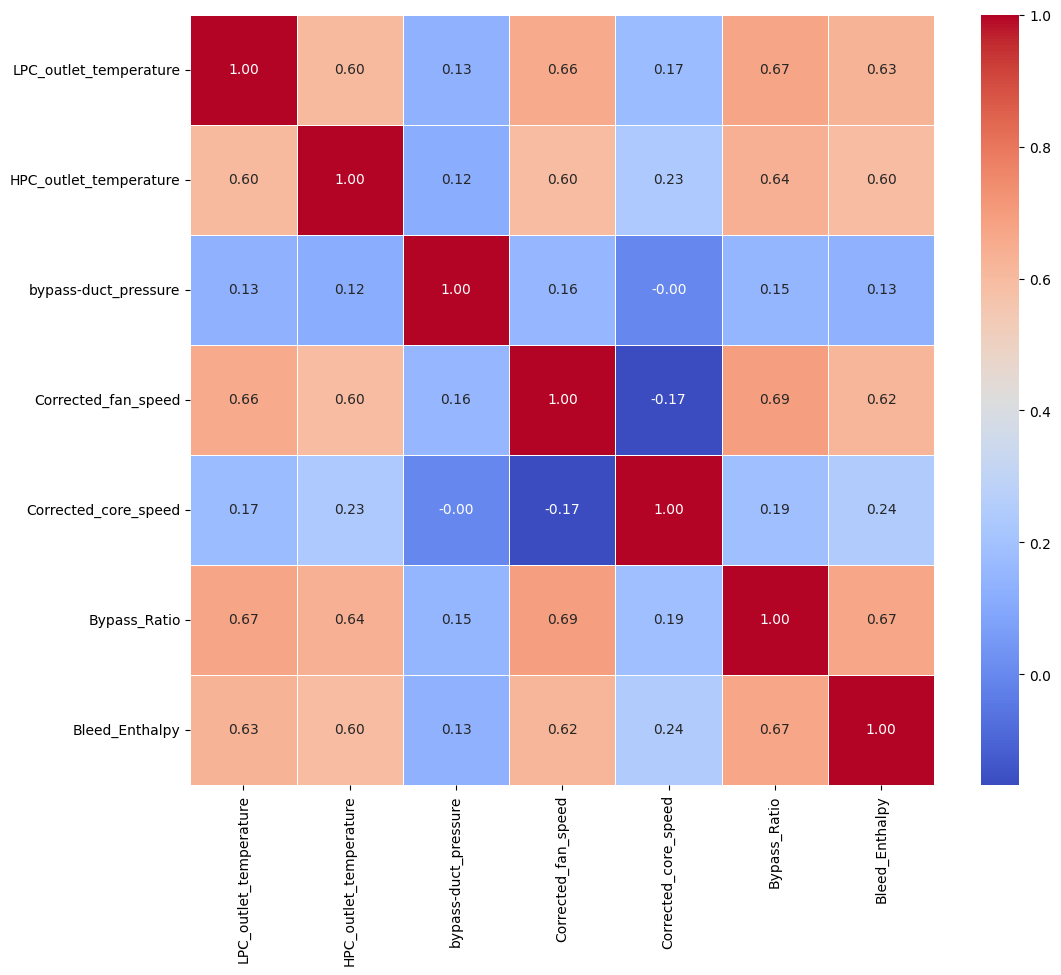

In [11]:
utils.draw_corr(features_df)

In [12]:
scaler = MinMaxScaler()
cols = df.columns[df.columns != "engine_id"]
cols = cols[cols != "time"]
cols = cols[cols != "rul"]
df[cols] = scaler.fit_transform(df[cols])
df.describe()
df = df.drop(["bypass-duct_pressure"], axis=1)  # prawie stałe wartości ?

In [13]:

# df_smooth = df.copy()
# columns_to_smooth = [col for col in df_smooth.columns if col not in ['time', 'engine_id']]
# frac = 1.
# for col in columns_to_smooth:
#     smoothed_values = []
#     for _, group in df_smooth.groupby('engine_id'):
#         smoothed = lowess(group[col], group['time'], frac=frac)[:, 1]
#         smoothed_values.extend(smoothed)
#     df_smooth[col] = smoothed_values
df_with_smooth_cols = utils.lowess_features(df, 1)
df_with_smooth_cols

engine_id  time  LPC_outlet_temperature  HPC_outlet_temperature  \
0            1     1                0.183735                0.406802   
1            1     2                0.283133                0.453019   
2            1     3                0.343373                0.369523   
3            1     4                0.343373                0.256159   
4            1     5                0.349398                0.257467   
..         ...   ...                     ...                     ...   
187          1   188                0.765060                0.683235   
188          1   189                0.894578                0.547853   
189          1   190                0.731928                0.614345   
190          1   191                0.641566                0.682799   
191          1   192                0.701807                0.662089   

     Corrected_fan_speed  Corrected_core_speed  Bypass_Ratio  Bleed_Enthalpy  \
0               0.205882              0.199608      0.363986        0.333333   
1               0.279412              0.162813      0.411312        0.333333   
2               0.220588              0.171793      0.357445        0.166667   
3               0.294118              0.174889      0.166603        0.333333   
4               0.235294              0.174734      0.402078        0.416667   
..                   ...                   ...           ...             ...   
187             0.514706              0.091599      0.753367        0.666667   
188             0.661765              0.090670      0.744132        0.583333   
189             0.691176              0.065229      0.759523        0.833333   
190             0.617647              0.075704      0.740669        0.500000   
191             0.647059              0.056714      0.717199        0.666667   

     LPC_outlet_temperature_lowess  HPC_outlet_temperature_lowess  \
0                         0.293778                       0.321054   
1                         0.294692                       0.321456   
2                         0.295610                       0.321862   
3                         0.296530                       0.322271   
4                         0.297454                       0.322684   
..                             ...                            ...   
187                       0.622884                       0.563110   
188                       0.625578                       0.565355   
189                       0.628276                       0.567605   
190                       0.630980                       0.569859   
191                       0.633689                       0.572118   

     Corrected_fan_speed_lowess  Corrected_core_speed_lowess  \
0                      0.217945                     0.172753   
1                      0.218878                     0.172612   
2                      0.219813                     0.172471   
3                      0.220749                     0.172329   
4                      0.221688                     0.172187   
..                          ...                          ...   
187                    0.524579                     0.107470   
188                    0.527016                     0.106875   
189                    0.529457                     0.106279   
190                    0.531902                     0.105682   
191                    0.534351                     0.105083   

     Bypass_Ratio_lowess  Bleed_Enthalpy_lowess  
0               0.314117               0.299815  
1               0.314972               0.300558  
2               0.315829               0.301303  
3               0.316687               0.302052  
4               0.317547               0.302803  
..                   ...                    ...  
187             0.625402               0.566159  
188             0.628064               0.568310  
189             0.630734               0.570465  
190             0.633411               0.572624  
191             0.636095       

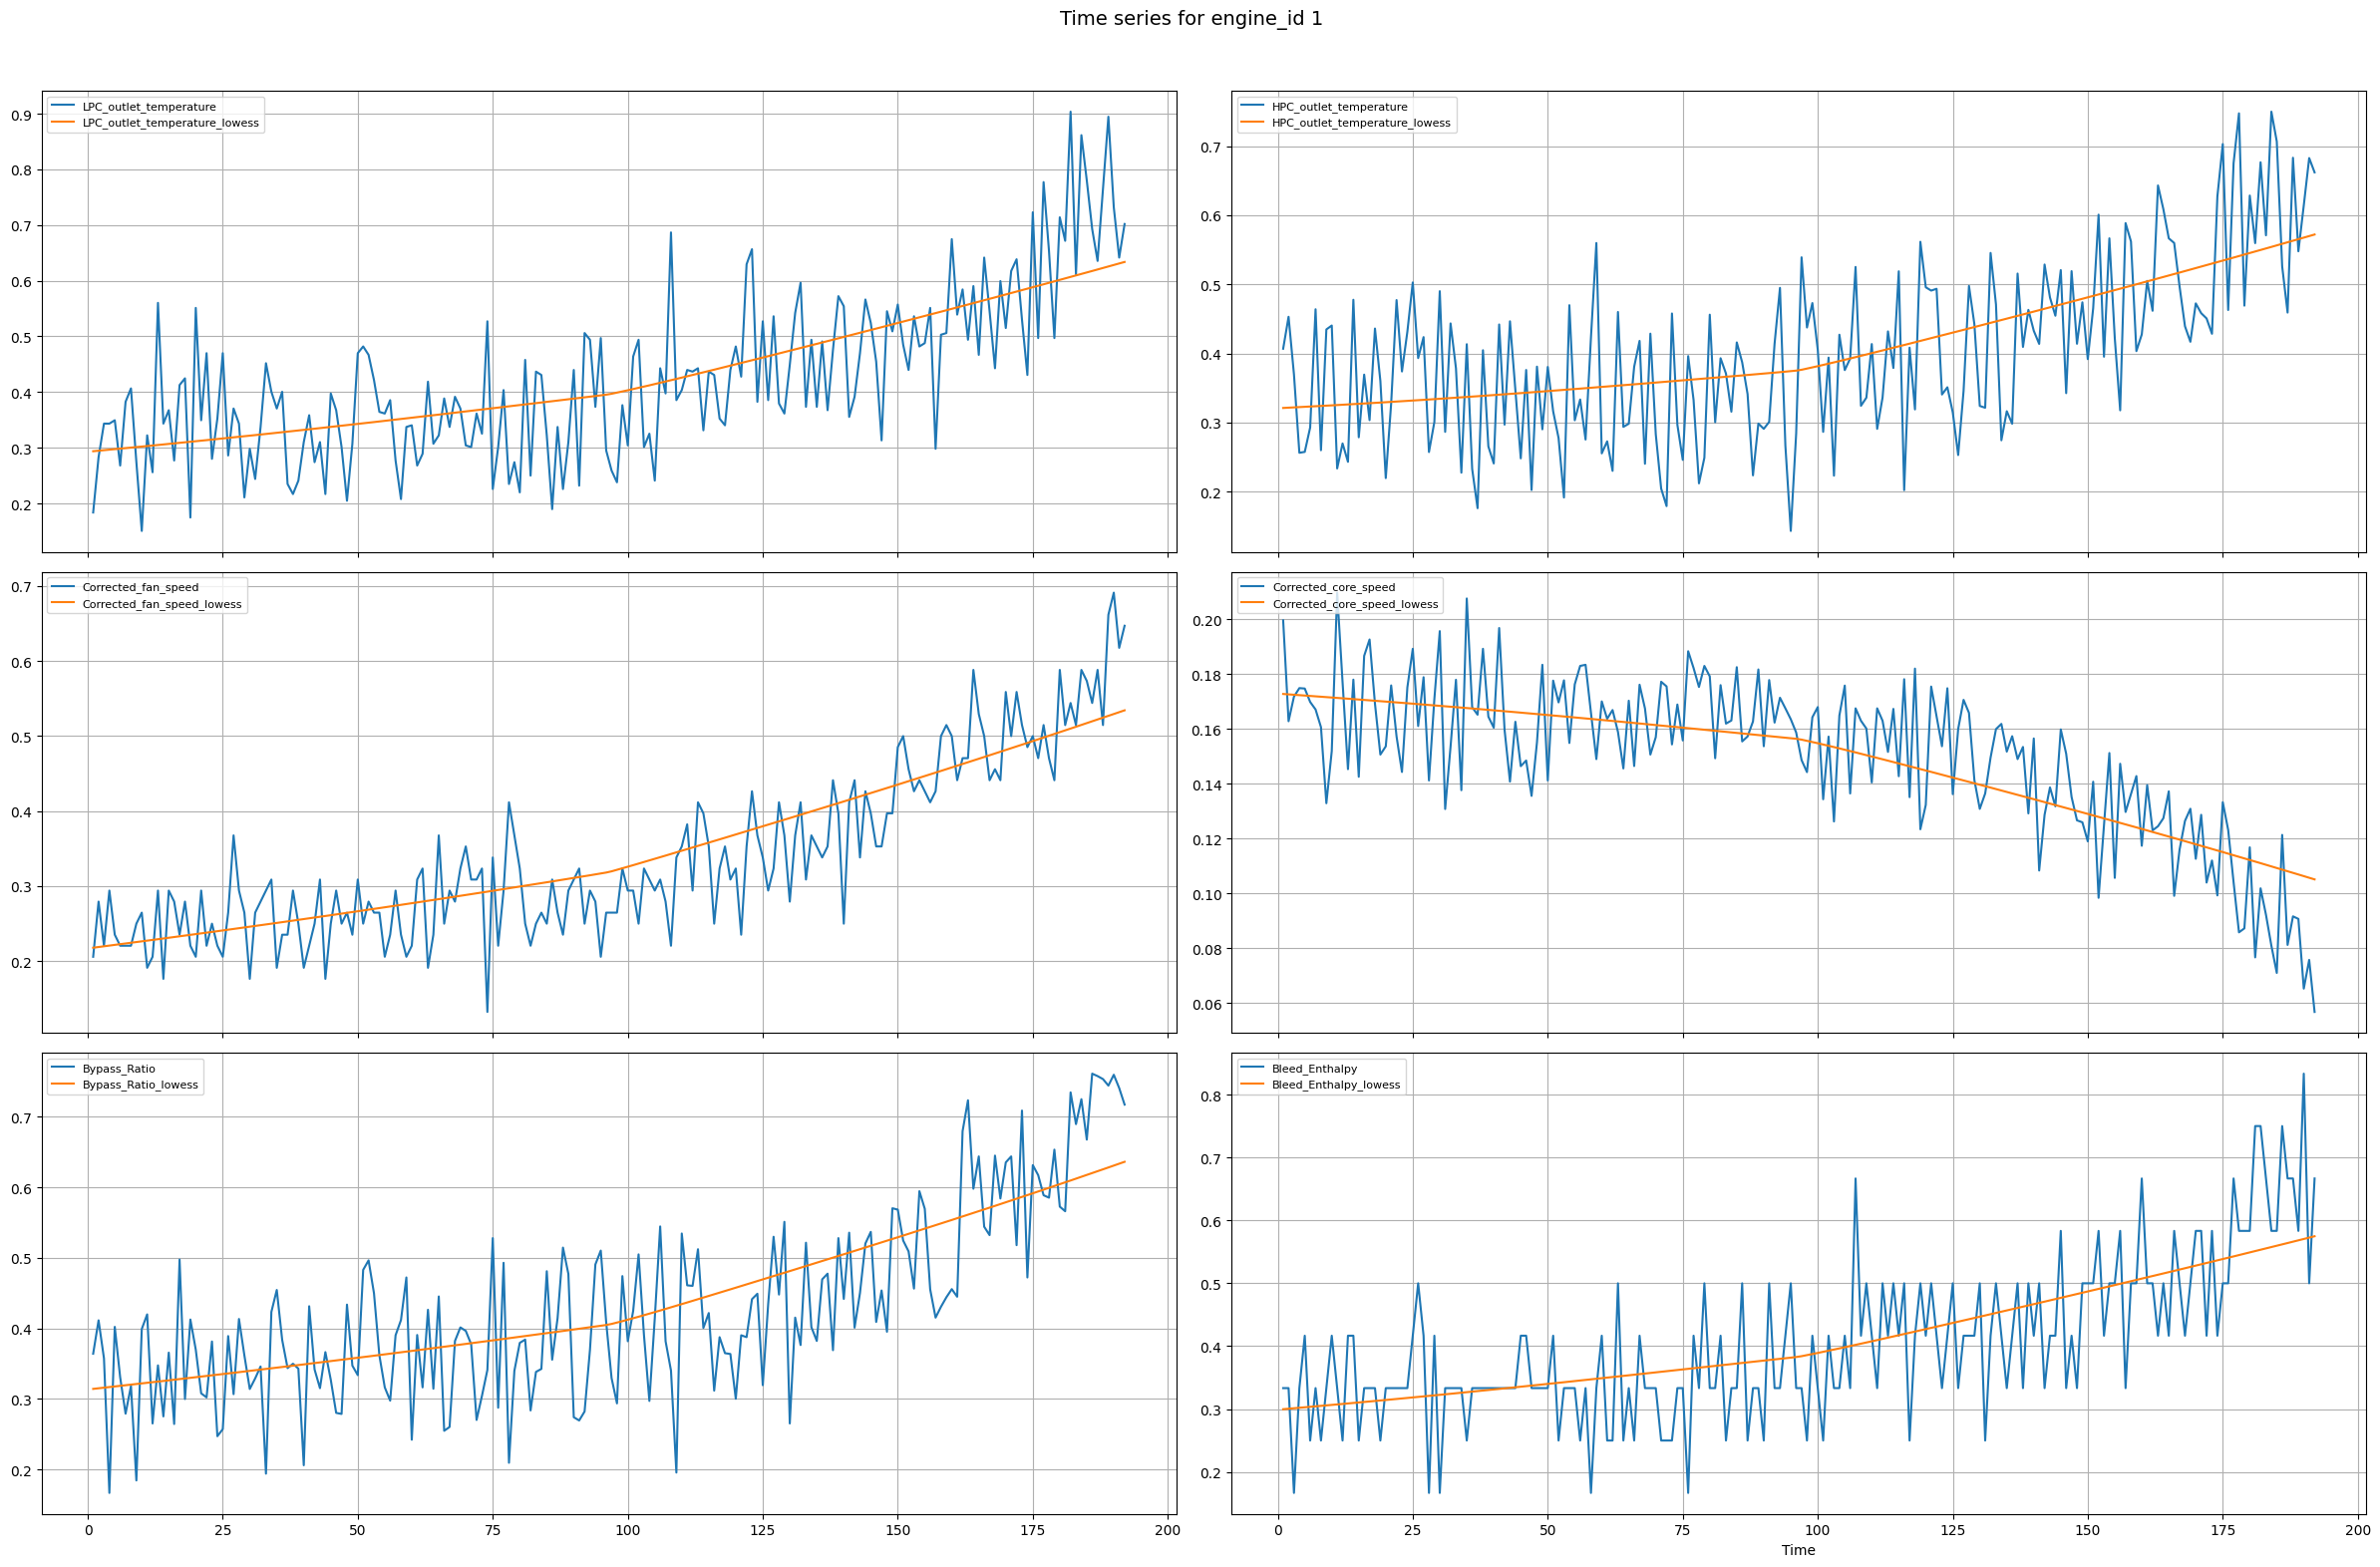

In [14]:
utils.draw_time_series(df_with_smooth_cols, 1)

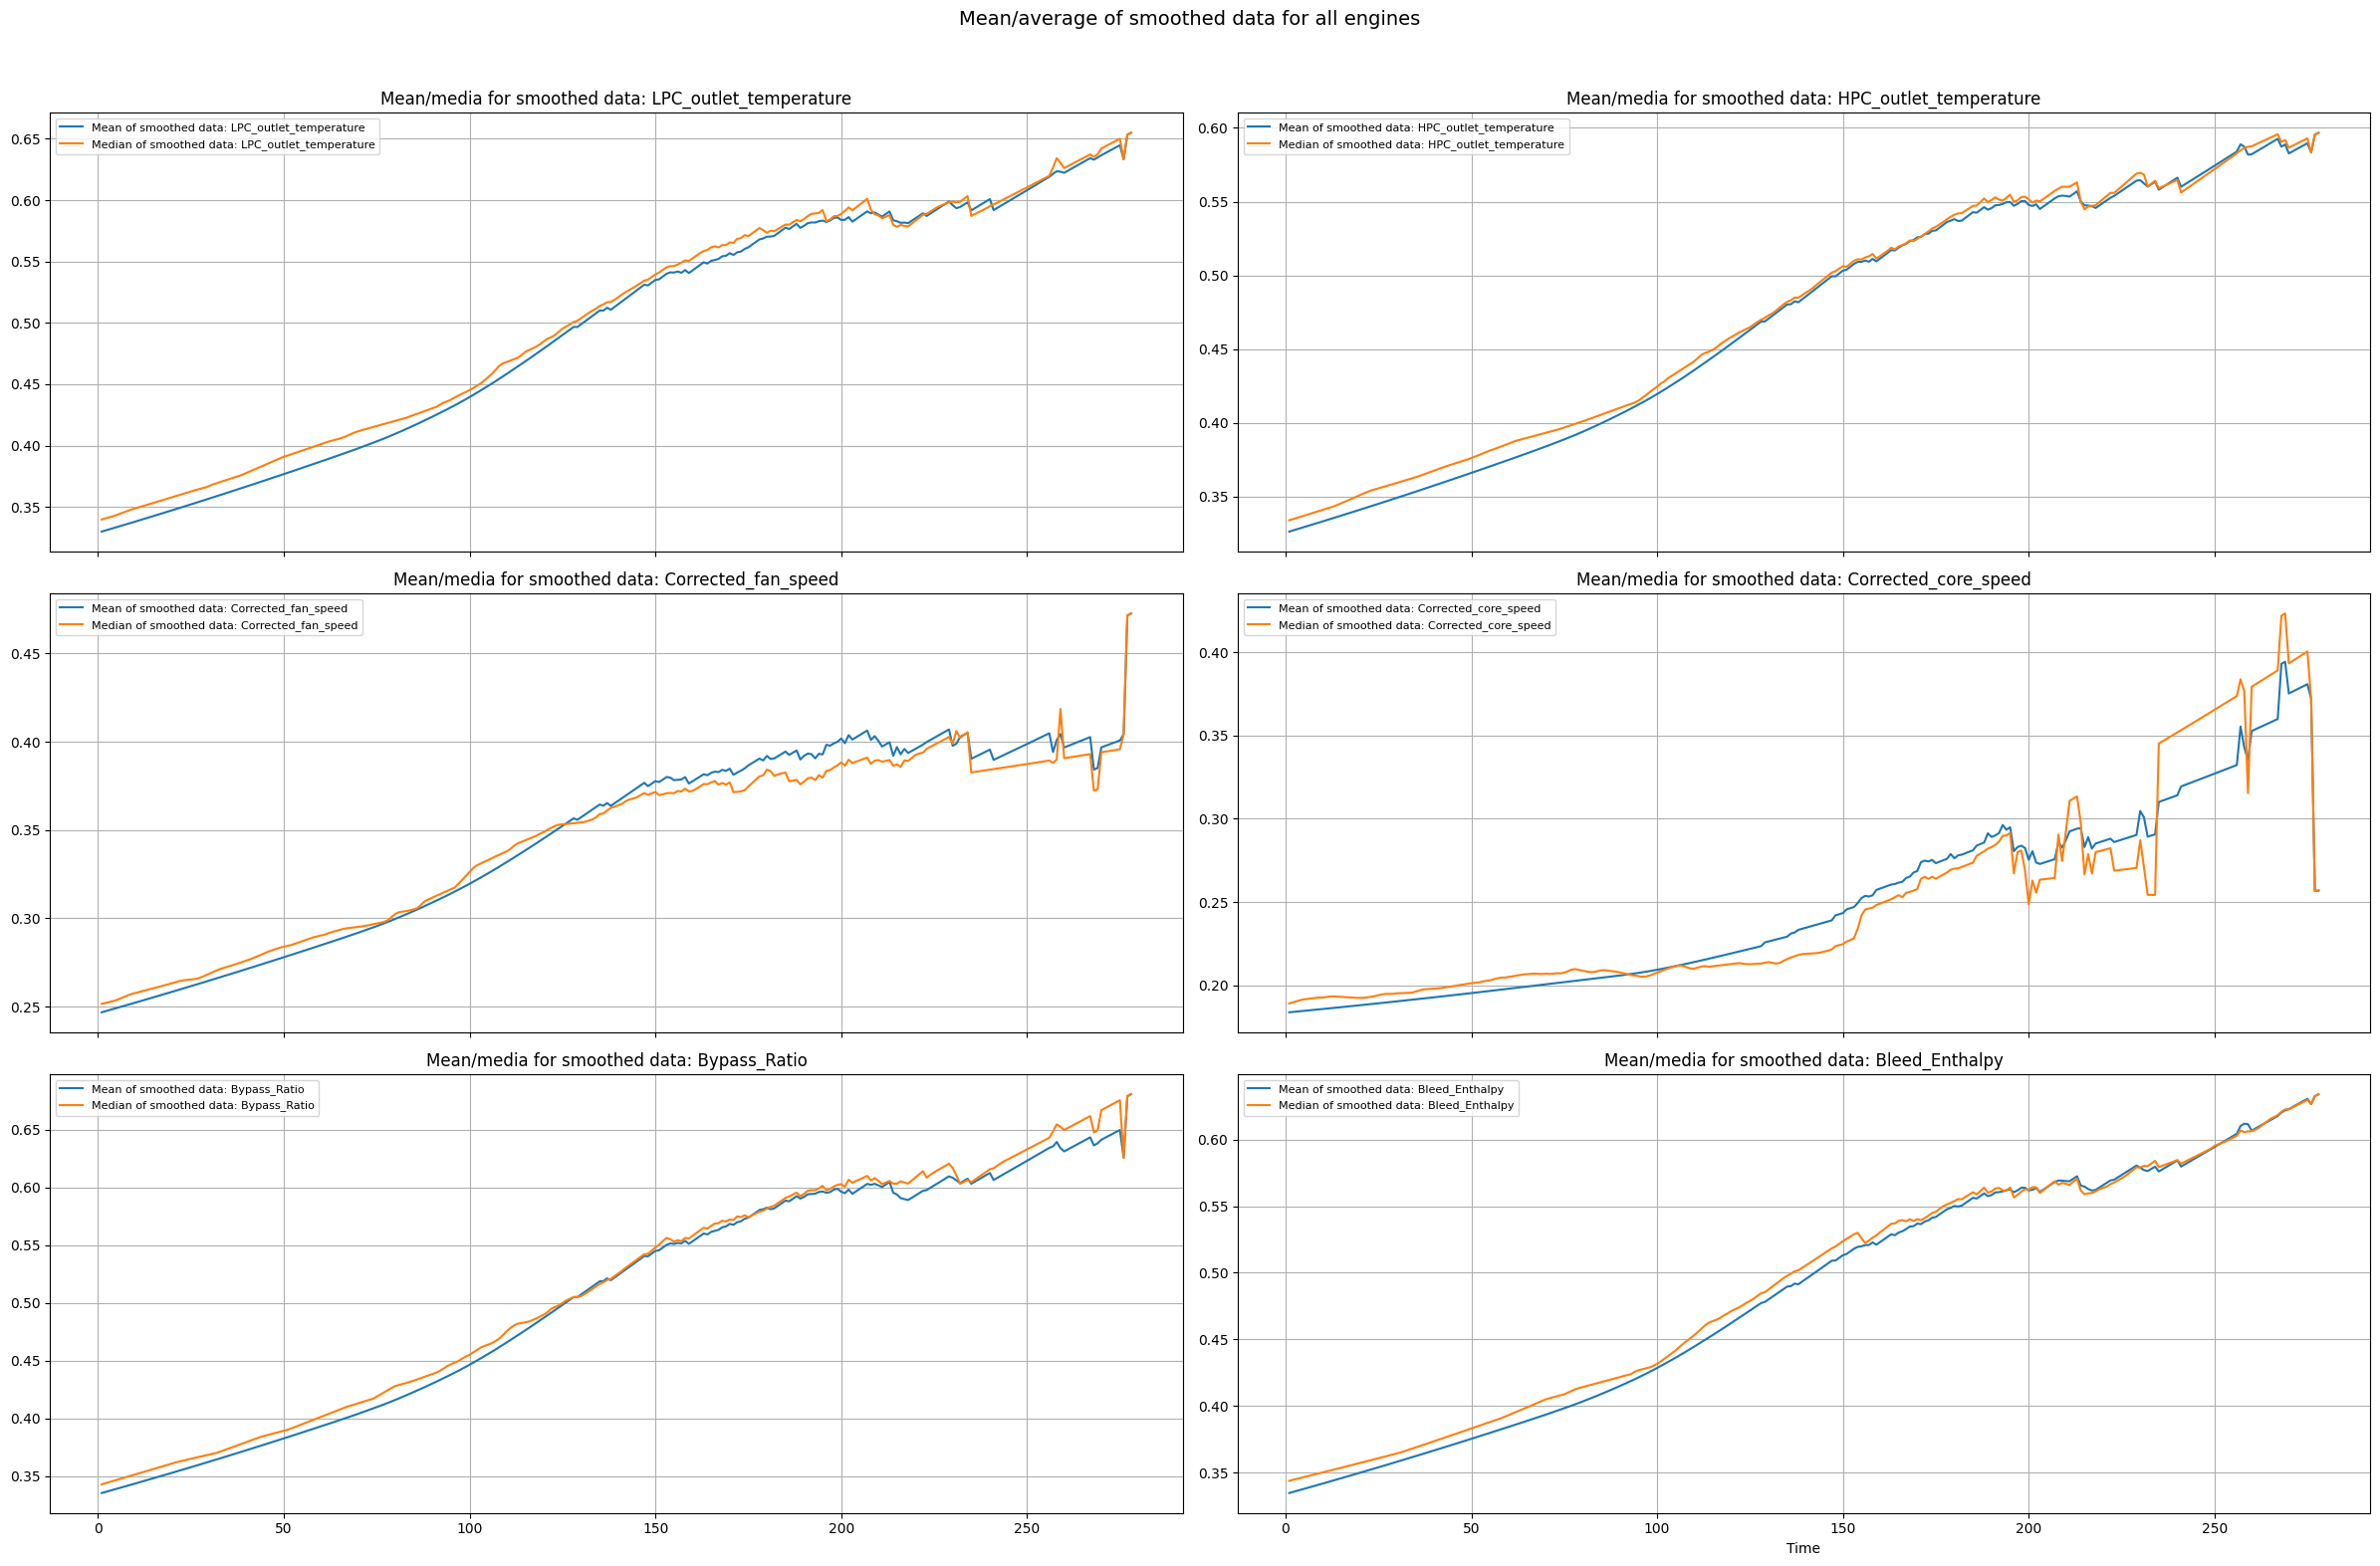

In [15]:
df_smooth = utils.lowess_features_overwrite(df)
utils.draw_time_series_for_all_engines(df_smooth)

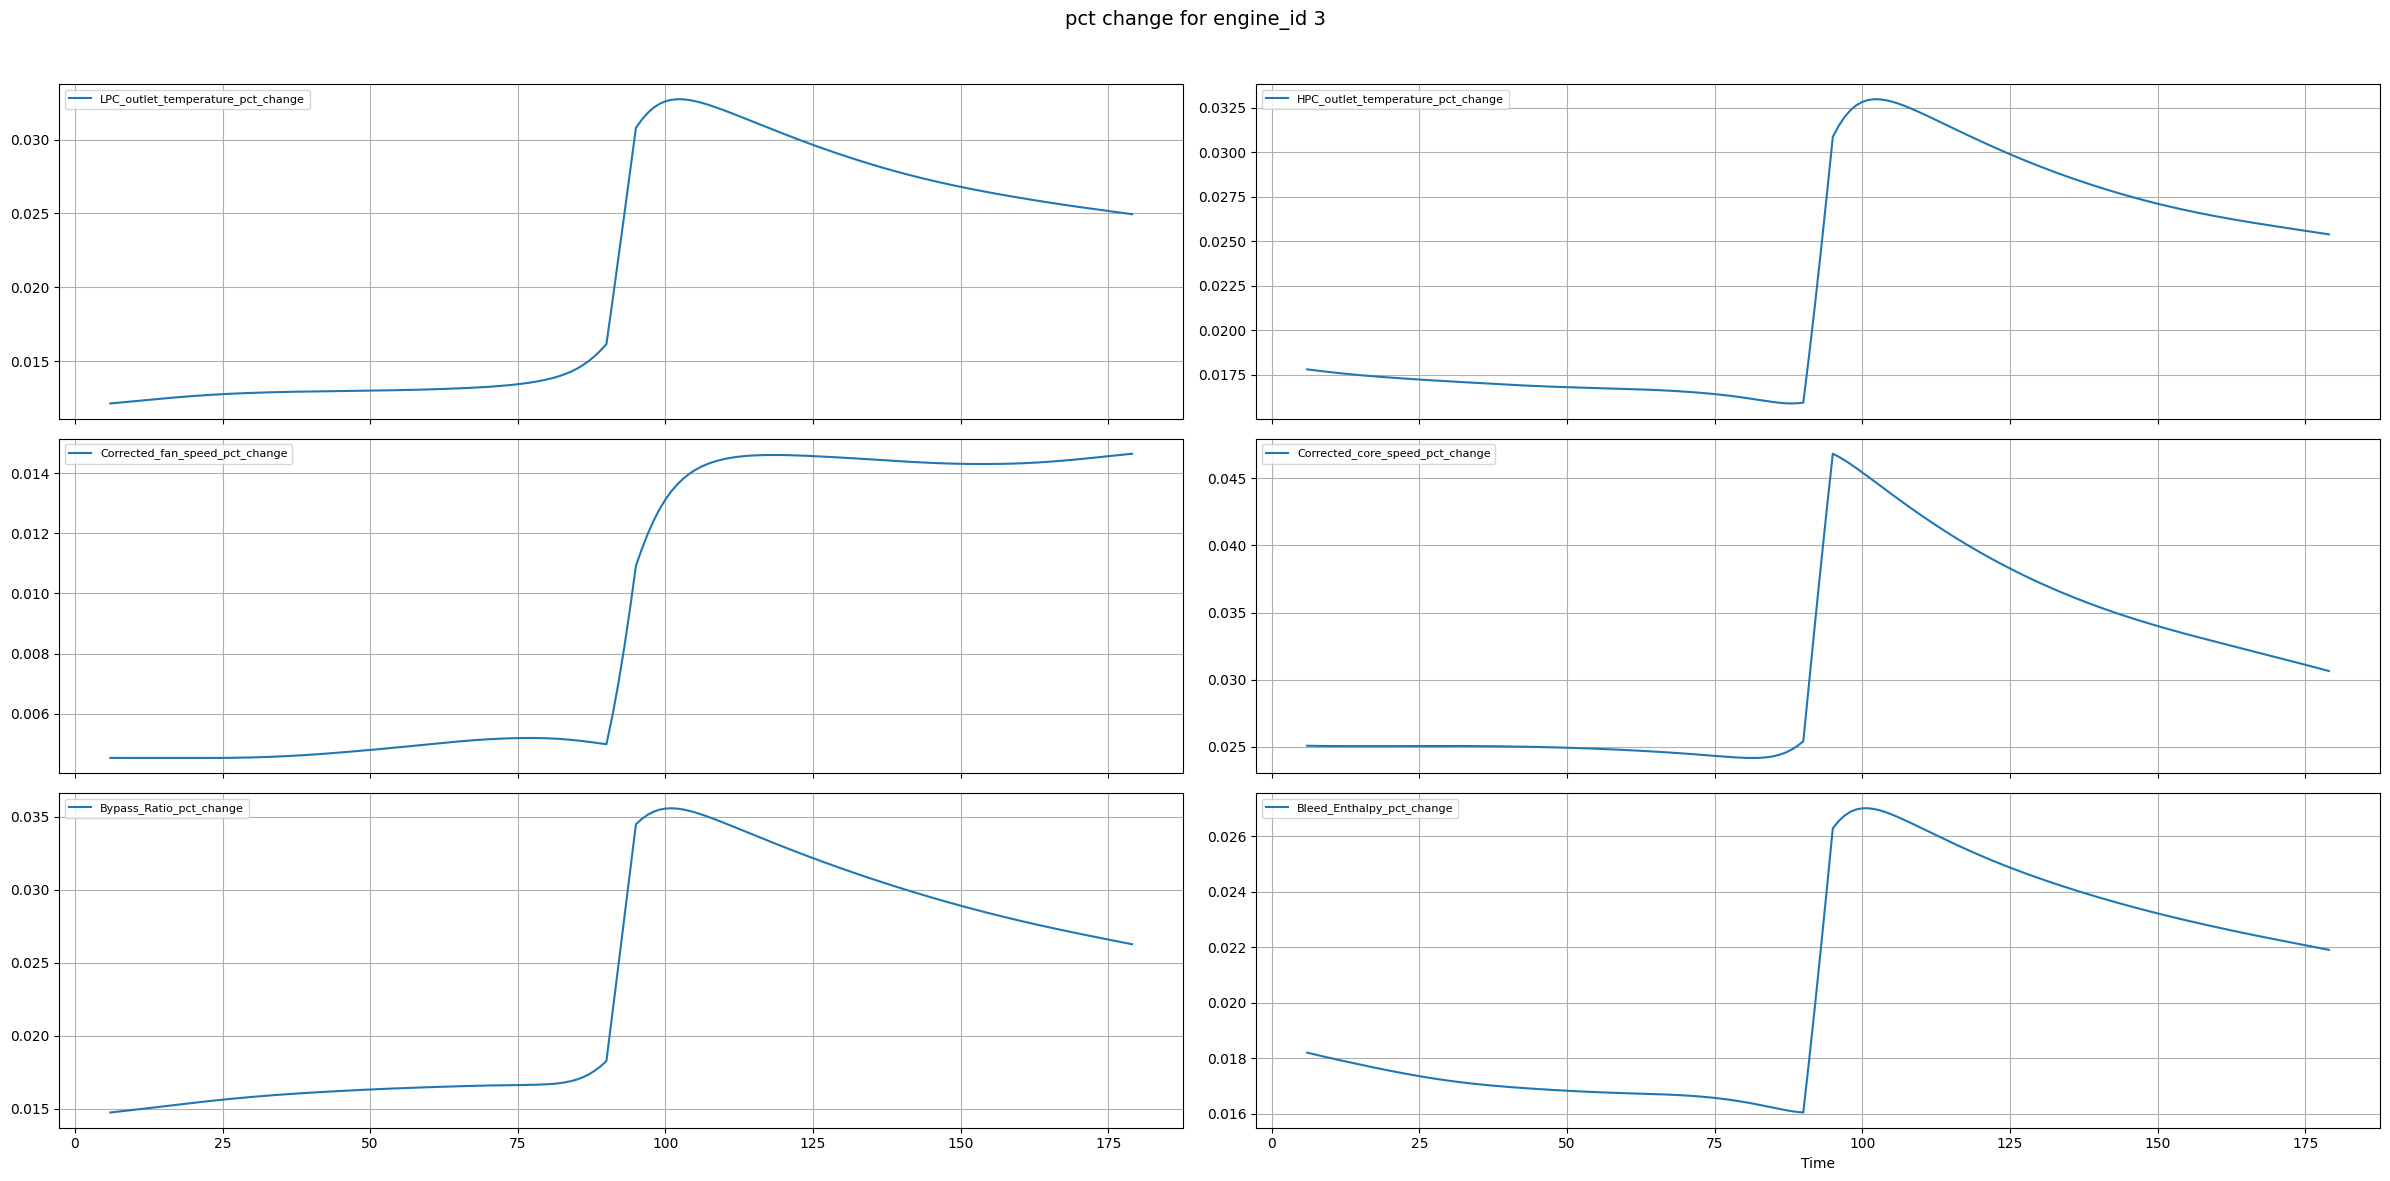

In [16]:
df_with_pctchange = pct_change(df_smooth, 5)
df_with_pctchange['rul'] = df.groupby('engine_id')['time'].transform('max') - df['time']
draw_pct_change(df_with_pctchange, 3)

In [17]:
features = list(df_with_pctchange.columns)
features.remove('engine_id')
y = df_with_pctchange.groupby('engine_id')['time'].transform('max') - df_with_pctchange['time']
X = df_with_pctchange[features].drop(['rul'], axis=1)
X

time  LPC_outlet_temperature  HPC_outlet_temperature  \
5         6                0.298381                0.323100   
6         7                0.299311                0.323520   
7         8                0.300245                0.323945   
8         9                0.301182                0.324372   
9        10                0.302122                0.324804   
...     ...                     ...                     ...   
20626   196                0.645888                0.604129   
20627   197                0.648142                0.606080   
20628   198                0.650399                0.608034   
20629   199                0.652659                0.609991   
20630   200                0.654923                0.611951   

       Corrected_fan_speed  Corrected_core_speed  Bypass_Ratio  \
5                 0.222630              0.172044      0.318408   
6                 0.223573              0.171901      0.319271   
7                 0.224519              0.171757      0.320136   
8                 0.225466              0.171612      0.321003   
9                 0.226417              0.171467      0.321871   
...                    ...                   ...           ...   
20626             0.482667              0.215763      0.667626   
20627             0.484552              0.215674      0.670169   
20628             0.486441              0.215585      0.672718   
20629             0.488332              0.215495      0.675271   
20630             0.490227              0.215405      0.677829   

       Bleed_Enthalpy  LPC_outlet_temperature_pct_change  \
5            0.303557                           0.015669   
6            0.304315                           0.015673   
7            0.305075                           0.015679   
8            0.305838                           0.015685   
9            0.306605                           0.015693   
...               ...                                ...   
20626        0.611773                           0.017670   
20627        0.613596                           0.017636   
20628        0.615422                           0.017602   
20629        0.617252                           0.017567   
20630        0.619084                           0.017533   

       HPC_outlet_temperature_pct_change  Corrected_fan_speed_pct_change  \
5                               0.006373                        0.021492   
6                               0.006422                        0.021450   
7                               0.006472                        0.021408   
8                               0.006522                        0.021368   
9                               0.006572                        0.021328   
...                                  ...                             ...   
20626                           0.016330                        0.019805   
20627                           0.016304                        0.019763   
20628                           0.016277                        0.019722   
20629                           0.016251                        0.019680   
20630                           0.016224                        0.019638   

       Corrected_core_speed_pct_change  Bypass_Ratio_pct_change  \
5                            -0.004104                 0.013660   
6                            -0.004122                 0.013649   
7                            -0.004141                 0.013639   
8                            -0.004161                 0.013629   
9                            -0.004180                 0.013619   
...                                ...                      ...   
20626                        -0.002007                 0.019299   
20627                        -0.002022                 0.019264   
20628                        -0.002037                 0.019228   
20629                        -0.002052                 0.019193   
20630                        -0.002067                 0.019157   

       Bleed_Entha

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [20]:
y_pred

array([130.83586075,   6.87921084,  42.30242572, ..., 147.16723064,
        80.97426416, 154.27186098])

In [21]:
y_test

7689     136
10772     14
2517      28
6001     219
20299    131
        ... 
19091    177
11373     18
2965     130
20345     85
19075    193
Name: time, Length: 3535, dtype: int64

In [22]:
utils.evaluate(y_test, y_pred)

test set RMSE:19.297352443643568, R2:0.9008133949645822


In [23]:
from mapie.regression import MapieRegressor

alphas = [0.2]
mapie_reg = MapieRegressor(estimator=model)
mapie_reg = mapie_reg.fit(X_train, y_train)

y_pred, y_pis = mapie_reg.predict(X_test, alpha=alphas)


In [25]:
max(y_pis[:, 0, :])
# średni RUL to granica, robimy max(rul_pred, średnia)
#jaka metryka do modelu???
# ile cykli, żeby sensownie oszacować RUL?

array([185.27112928])

In [26]:
y_pred1 = y_pis[:, 0, :]
y_pred2 = y_pis[:, 1, :]

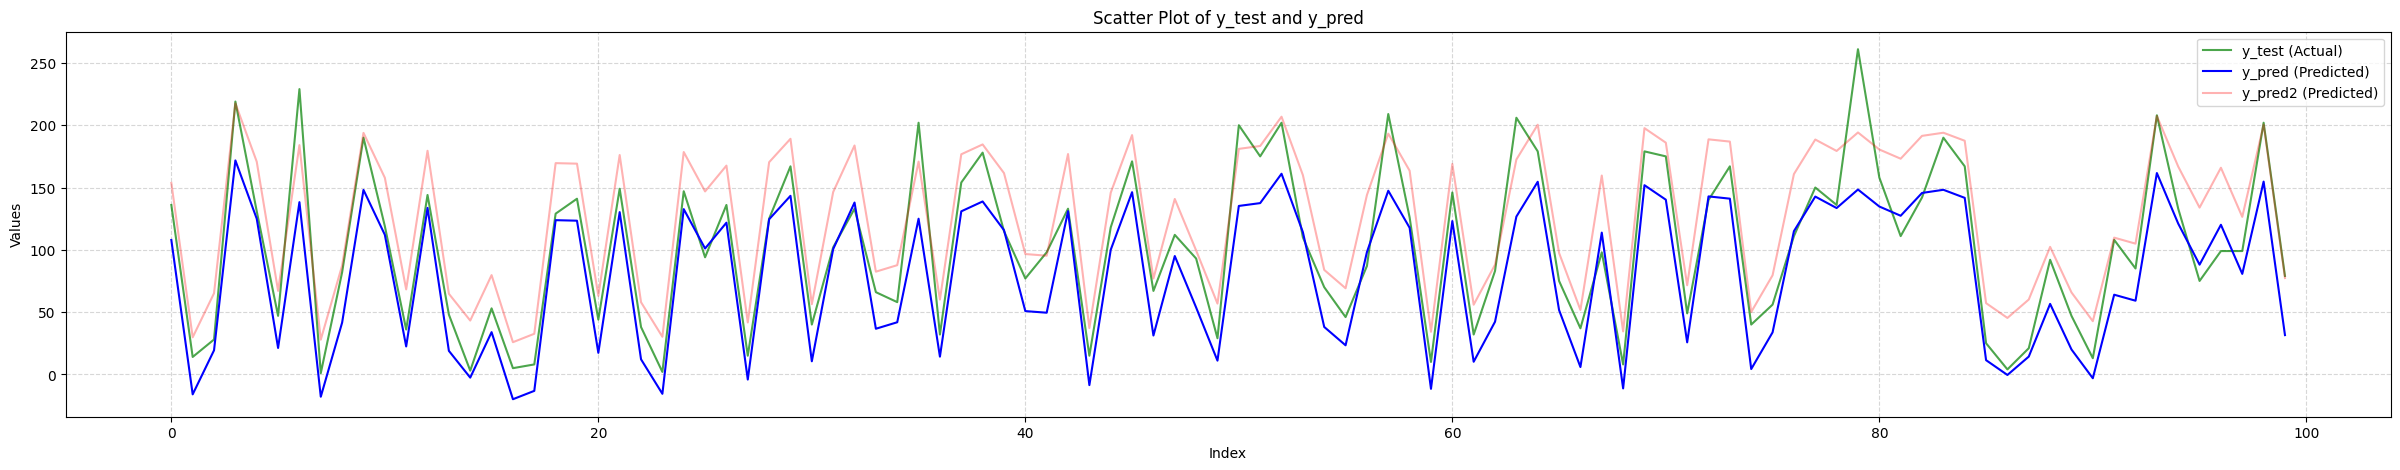

In [29]:
plt.figure(figsize=(30, 5))
size = 100
plt.plot(range(size), y_test[:size], color='green', label='y_test (Actual)', alpha=0.7)
plt.plot(range(size), y_pred1[:size], color='blue', label='y_pred (Predicted)', alpha=1.)
plt.plot(range(size), y_pred2[:size], color='red', label='y_pred2 (Predicted)', alpha=0.3)

# Add labels, title, legend, and grid
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Scatter Plot of y_test and y_pred")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()

### Test data

In [ ]:
test_df = utils.load_data("CMAPSSData/test_FD001.txt")
test_y = pd.read_csv("CMAPSSData/RUL_FD001.txt", sep=" ", header=None)
test_y.drop(axis=1, columns=[1], inplace=True)
features_to_keep = ['engine_id', 'time', 'LPC_outlet_temperature', 'HPC_outlet_temperature',
                    'bypass-duct_pressure', 'Corrected_fan_speed', 'Corrected_core_speed',
                    'Bypass_Ratio', 'Bleed_Enthalpy']
test_df = test_df[features_to_keep]
features = list(test_df.columns)
features.remove('time')
features.remove('engine_id')
test_df[features] = scaler.transform(test_df[features])
# test_df_with_pctchange = pct_change(test_df, features)
test_df_with_pctchange = test_df.copy()


In [ ]:

test_df_with_pctchange

In [ ]:
max_time_df = test_df_with_pctchange.loc[test_df_with_pctchange.groupby('engine_id')['time'].idxmax()]
max_time_df

In [ ]:
X = max_time_df.drop(['engine_id'], axis=1)
alphas = [0.1]
result = mapie_reg.predict(X, alpha=alphas)

In [ ]:
def evaluate_mapie_output(result, draw_size=100):
    plt.figure(figsize=(30, 5))
    y_pred, y_intervals = result
    y_pred_min = y_intervals[:, 0, :].clip(min=0)
    y_pred_max = y_intervals[:, 1, :]
    plt.plot(range(1, draw_size + 1), test_y[:draw_size], color='gold', label='RUL (Actual)', alpha=0.7)
    plt.plot(range(1, draw_size + 1), y_pred_min[:draw_size], color='blue', label='lower RUL bound (Predicted)',
             alpha=0.7)
    plt.xlabel("Engine ID")
    plt.ylabel("RUL")
    plt.title("Scatter Plot of y_test and y_pred")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


In [ ]:
evaluate_mapie_output(result)

In [ ]:
plt.figure(figsize=(30, 5))
y_pred, y_intervals = result
y_pred_min = y_intervals[:, 0, :].clip(min=0)
y_pred_max = y_intervals[:, 1, :]
plt.scatter(range(1, 100 + 1), test_y[:100] - y_pred_min[:100], color='gold',
            label='RUL (difference between actual and prediction)', alpha=0.7)
plt.plot(range(1, 100 + 1), y_pred_min[:100].clip(min=0, max=0), color='red', alpha=0.7)

plt.xlabel("Engine ID")
plt.ylabel("RUL")
plt.title("Difference between estimated and actual RUL. Negative values indicate overshoot (bad)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()